 # Notebook 04: Introduction to PyTorch



 ### Primary Goal: Introduce `torch`



 #### Background



 [PyTorch](https://pytorch.org/)



 What is it?



 - A Facebook (Meta) maintained open-source package that does all things neural networks. It is known for its dynamic computation graph and Pythonic nature.



 Why don't we use `sklearn`?



 - `sklearn` does have a multi-layer perceptron [method](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), but currently there is no support for convolutional neural networks or complex custom architectures. You could use `sklearn` for ANNs, but `pytorch` is significantly more flexible and is the dominant framework in modern research. Furthermore, PyTorch has built-in GPU support, which will help accelerate training.



 Where can I find more tutorials about PyTorch?



 - `pytorch` has many good [tutorials](https://pytorch.org/tutorials/) on how to use their package. Just be aware that their datasets are not weather related (e.g., images of hand written digits, low-resolution pictures of dogs and cats), so adapting their methods to meteorology examples can be challenging.





 #### Step 1: Imports



 Just like `matplotlib.pyplot` is abbreviated as `plt` and `numpy` is abbreviated as `np`, `pytorch` is imported as `torch`. We also import `torch.nn` which contains the neural network building blocks.

In [85]:

import torch
import torch.nn as nn
import torch.optim as optim

# one quick thing here, we need to set the random seed so we all get the same results no matter the computer or python session
_ = torch.manual_seed(42)


 #### Step 2: Build a model







 The most common way to build a simple feed-forward network in PyTorch is to use `nn.Sequential`. This is, as the name suggests, a container that passes inputs through a list of sequential layers. So you can envision that your data will *flow* through each entry of this `Sequential` model.



 The pieces that make up this model come from `torch.nn` and include linear layers (also known as dense or fully connected layers) and convolutional layers.



 Let's do an example. First we'll build a simple perceptron. Remember that a perceptron is a single-node network, so all we need to do is create a linear layer with one input feature and one output feature:

In [86]:
model = nn.Sequential(nn.Linear(in_features=1, out_features=1))


 Viola, you have your first neural network model built with PyTorch. If you want to see what you built, you can simply print the model object.

In [87]:
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


You should see above that it shows the architecture of the layers.

You can also parse the model object to get more details:

In [92]:
def param_summary(model: torch.nn.Module) -> None:
    print(f"{'Layer Name':<20} {'Shape':<20} {'Param #':<10}")
    print("-" * 50)

    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:<20} {str(list(param.shape)):<20} {param.numel():<10}")
            total_params += param.numel()
            
    print("-" * 50)
    print(f"{total_params=}")

param_summary(model)


Layer Name           Shape                Param #   
--------------------------------------------------
0.weight             [1, 1]               1         
0.bias               [1]                  1         
--------------------------------------------------
total_params=2


This example is very simple and is exactly linear regression in its current form. This is because by default the *activation* (remember the $\sigma$ function in the equation) is linear (or identity) unless we specify otherwise. So this model is just:



$$(w x + b)$$



where $w$ and $b$ are the trainable parameters. The cool thing about PyTorch is that you can access these parameters easily. To view them, we can look at the `state_dict` or access the specific layer's weight attribute:

In [83]:

# Access the first layer (index 0)

print("Weights:", model[0].weight)
print("Bias:", model[0].bias)


Weights: Parameter containing:
tensor([[0.7645]], requires_grad=True)
Bias: Parameter containing:
tensor([0.8300], requires_grad=True)


You should see two entries above, a *weight* and a *bias*. This is the $w$ and the $b$. For neural networks, PyTorch randomly initializes these weights using specific initialization schemes (often Kaiming or Xavier initialization) to ensure training starts effectively.



#### Step 3: Load some data



So far, all we have is a randomly initialized model. Next we need to actually train it on some data. Let's load in the pre-engineered data for our example and fit this model to predict the number of lightning strikes from the IR brightness temperature. This is the same simple task that we demonstrated in Part 1.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False
%config InlineBackend.figure_format = 'retina'


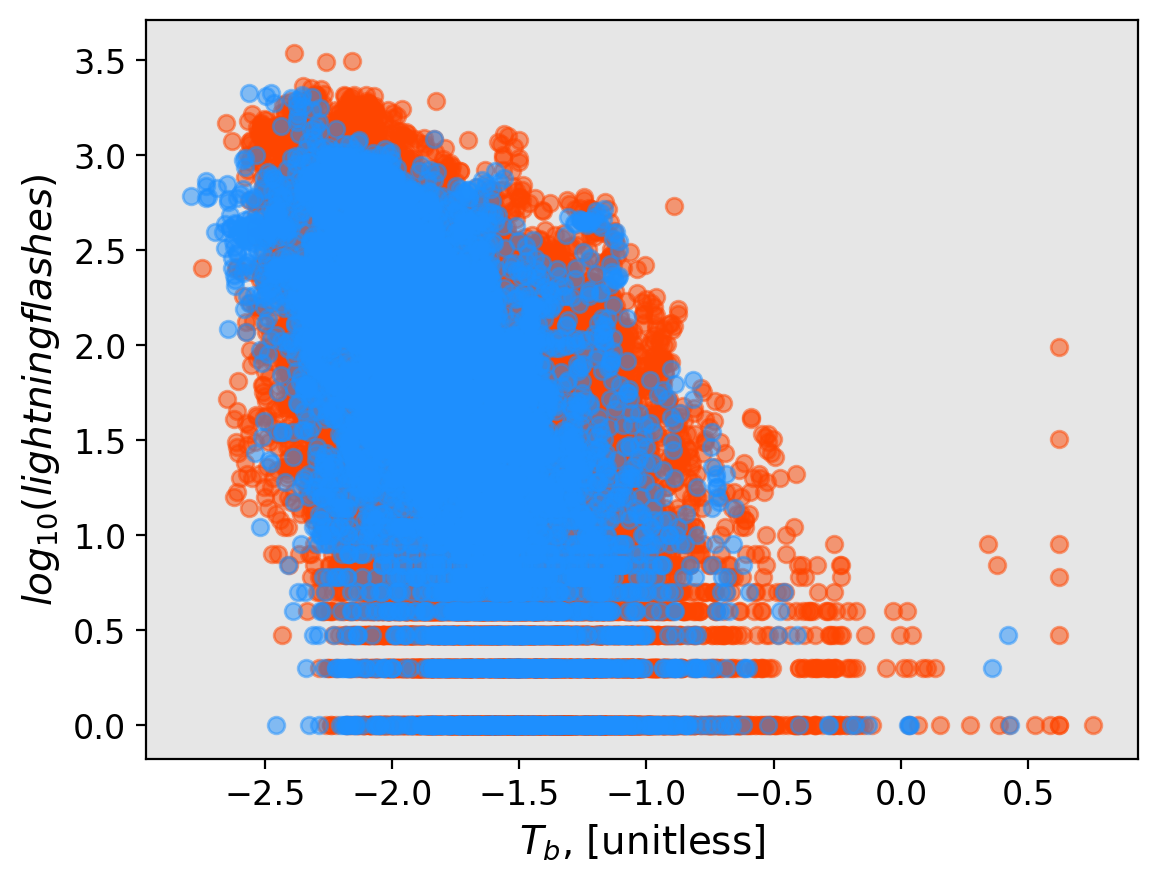

In [84]:
#load training
try:
    df_t = pd.read_csv('../datasets/sub-sevir-engineered/lowres_features_train.csv')
except FileNotFoundError:
    df_t = pd.read_csv('https://raw.githubusercontent.com/ai2es/WAF_ML_Tutorial_Part2/refs/heads/main/datasets/sub-sevir-engineered/lowres_features_train.csv')
#load validation set
try:
    df_v = pd.read_csv('../datasets/sub-sevir-engineered/lowres_features_val.csv')
except FileNotFoundError:
    df_v = pd.read_csv('https://raw.githubusercontent.com/ai2es/WAF_ML_Tutorial_Part2/refs/heads/main/datasets/sub-sevir-engineered/lowres_features_val.csv')
    
#drop non-lightning times
df_t = df_t.where(df_t.label_reg > 0).dropna()
df_v = df_v.where(df_v.label_reg > 0).dropna()

#grab the minimum brightness temperature for IR (q000_ir)
X_t = df_t.to_numpy()[:,0:1]
#take the log of y so we can get a linear regression to work
y_t = np.log10(df_t.to_numpy()[:,37])

#do the same for the validation set
X_v = df_v.to_numpy()[:,0:1]
y_v = np.log10(df_v.to_numpy()[:,37])

# IMPORTANT: Convert Numpy arrays to PyTorch Tensors
# PyTorch works with Tensors, which are similar to arrays but can live on GPU.
# We also cast them to float32, which is the standard precision for NNs.

X_t_tensor = torch.tensor(X_t, dtype=torch.float32)
y_t_tensor = torch.tensor(y_t, dtype=torch.float32).view(-1, 1) # reshape to match output

X_v_tensor = torch.tensor(X_v, dtype=torch.float32)
y_v_tensor = torch.tensor(y_v, dtype=torch.float32).view(-1, 1)

#plot to check it looks right
plt.plot(X_t,y_t,'o',color='orangered',alpha=0.5)
plt.plot(X_v,y_v,'o',color='dodgerblue',alpha=0.5)

plt.xlabel('$T_b$, [unitless]')
plt.ylabel('$log_{10}(lightning flashes)$')
plt.show()

 Okay, everything looks correct.



 Just as a quick check, let's see how the model would perform with just the randomly initialized parameters. Let's plug in linearly spaced values in x. To get the model output, we simply pass the tensor into the model like a function: `model(x)`.

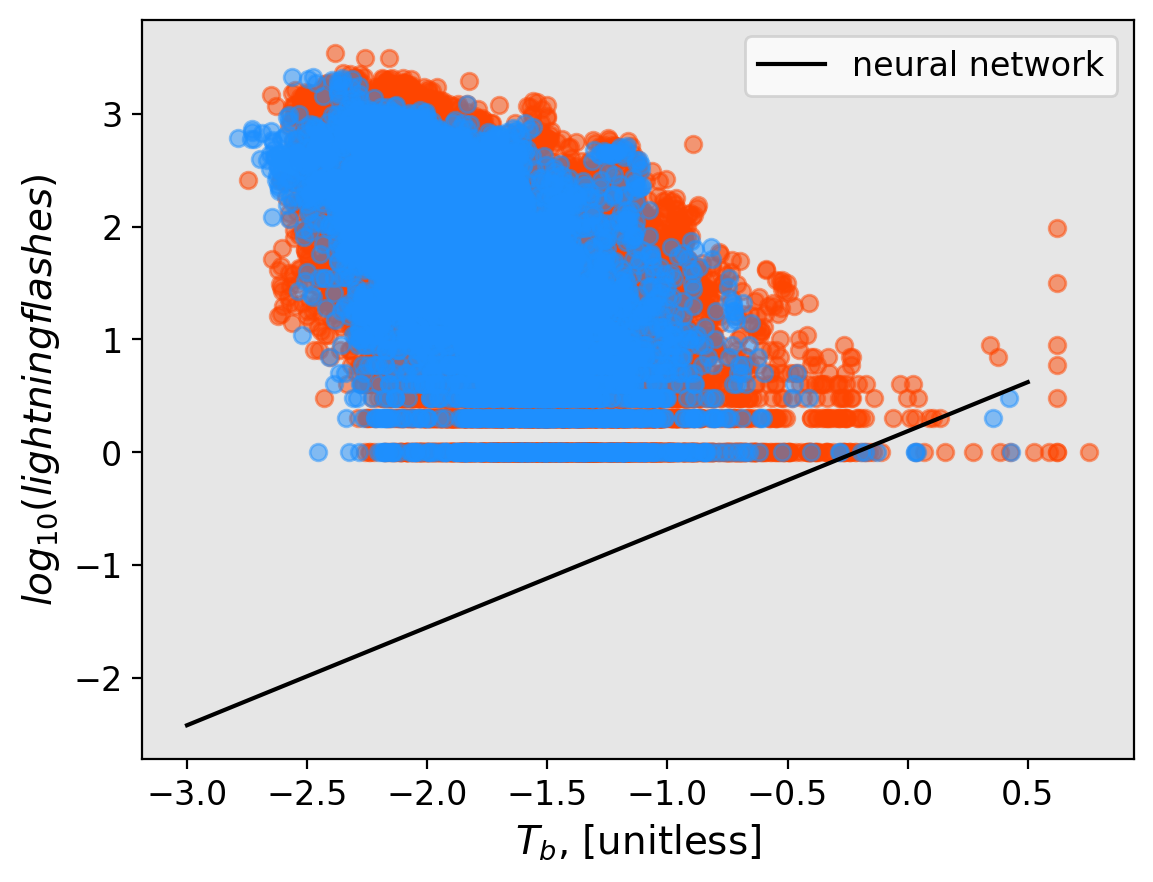

In [23]:

# Create dummy data and convert to tensor

x_dummy = np.linspace(-3,0.5).reshape(-1, 1)
x_dummy_tensor = torch.tensor(x_dummy, dtype=torch.float32)

# Set model to evaluation mode (good practice for inference)

model.eval()
with torch.no_grad(): # We don't need gradients for just looking at predictions
    yhat = model(x_dummy_tensor)

#plot to check it looks right
plt.plot(X_t,y_t,'o',color='orangered',alpha=0.5)
plt.plot(X_v,y_v,'o',color='dodgerblue',alpha=0.5)

plt.plot(x_dummy, yhat.numpy(),'-k',label='neural network')
plt.legend()
plt.xlabel('$T_b$, [unitless]')
plt.ylabel('$log_{10}(lightning flashes)$')
plt.show()

 It is pretty clear that the randomly initialized parameters would not work as is\! To improve this performance, we need to actually train the model\!

 #### Step 4: Define Loss and Optimizer



 Before we can train our model, we need to define how we calculate error (loss) and how we update weights (optimizer). To keep this example consistent with linear regression, we will choose the Mean Squared Error (MSE) as the loss function and Stochastic Gradient Descent (SGD) as the optimizer.

In [24]:

# 1. Define the loss function
loss_fn = nn.MSELoss()

# 2. Define the optimizer
# We pass in the model parameters that we want the optimizer to update
optimizer = optim.SGD(model.parameters(), lr=0.01)


 #### Step 5: Shuffle and batch



 Recall the discussion of how neural networks are trained. We train a neural network by asking the question, 'How can I change the weights such that it makes the model better?' We answer this by first calculating the gradient on a small subset of the training data (i.e., a batch), then take a small step (or change to the weights).



 To shuffle and batch the data, the PyTorch standard is to use a `Dataset` and a `DataLoader`.



 1\. `TensorDataset`: Wraps our tensors into a dataset object.

 2\. `DataLoader`: Handles the batching and shuffling automatically.

In [44]:
from torch.utils.data import TensorDataset, DataLoader

# Create a dataset from our tensors
train_ds = TensorDataset(X_t_tensor, y_t_tensor)

# Create a dataloader
# shuffle=True handles the randomization for us!
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


 We can loop through this `DataLoader` to see each batch. The loader automatically handles shuffling the data at the start of every iteration (epoch).

In [47]:
#just loop over the first 5 batches.
for i, (x_batch, y_batch) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"\tx_shape={x_batch.shape}, y_shape={y_batch.shape}")
    print(f"\tx_0={x_batch[0]}, y_0={y_batch[0]}")
    if i == 4:
        break


Batch 0:
	x_shape=torch.Size([32, 1]), y_shape=torch.Size([32, 1])
	x_0=tensor([-0.9077]), y_0=tensor([0.4771])
Batch 1:
	x_shape=torch.Size([32, 1]), y_shape=torch.Size([32, 1])
	x_0=tensor([-1.4476]), y_0=tensor([0.7782])
Batch 2:
	x_shape=torch.Size([32, 1]), y_shape=torch.Size([32, 1])
	x_0=tensor([-1.6758]), y_0=tensor([1.7634])
Batch 3:
	x_shape=torch.Size([32, 1]), y_shape=torch.Size([32, 1])
	x_0=tensor([-1.9695]), y_0=tensor([2.9731])
Batch 4:
	x_shape=torch.Size([32, 1]), y_shape=torch.Size([32, 1])
	x_0=tensor([-1.9889]), y_0=tensor([1.8261])


You can see above that now the x variable is of size [32, 1] (which is 1 batch). We are now finally ready to train the perceptron.

If you run the above cell multuple times you can see the first value in the first four batches changes each time - the shuffling is working. You can verify this by recreating `train_loader` with `shuffle=False` then re-running the above cell. The values will not change then.

We chose stochastic gradient descent as the optimizer for this model, and as such, it is important that order of training examples are randomized on each iteration of the training (hence why the optimizer is 'stochastic').  Therefore, we need to shuffle the data at the start of each epoch. 

You have probably noticed the word 'Tensor' by now. You dont have to worry about this too much, it is just a fancy numpy array that helps with the neural network gradients. But as expected, the above loop shows that there is one x value and one y value for each example. 



#### Step 6: Train the model



Unlike some high-level APIs that hide the training loop behind a single command, PyTorch requires you to write the training loop explicitly. This gives you immense control over exactly what happens during training.



The standard PyTorch training loop has 5 steps:

1. **Zero Gradients**: Clear old gradients from the previous step.
2. **Forward pass**: Compute prediction.
3. **Compute Loss**: Compare prediction to actual.
4. **Backward pass**: Calculate the gradient of the loss with respect to weights.
5. **Step**: Update the weights using the optimizer.

In [28]:
# Define number of epochs
num_epochs = 1

# Set model to training mode
model.train()

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch}...')

    # Iterate over batches
    for i, (x_batch, y_batch) in enumerate(train_loader):
        
        # 1. Zero gradients (clear previous steps) for every batch
        optimizer.zero_grad()

        # 2. Forward pass - make model predictions
        predictions = model(x_batch)
        
        # 3. Calculate Loss
        loss = loss_fn(predictions, y_batch)
        
        # 4. Backward pass (calculate gradients)
        loss.backward()
        
        # 5. Optimizer step (update weights)
        optimizer.step()
        
    print(f'Epoch {epoch} finished. Final batch loss: {loss.item():.4f}')



Starting Epoch 0...
Epoch 0 finished. Final batch loss: 0.2652


 Let's see how well the model performs after iterating over the dataset once\! We switch the model to evaluation mode using `model.eval()` before predicting.

Text(0, 0.5, '$log_{10}(lightning flashes)$')

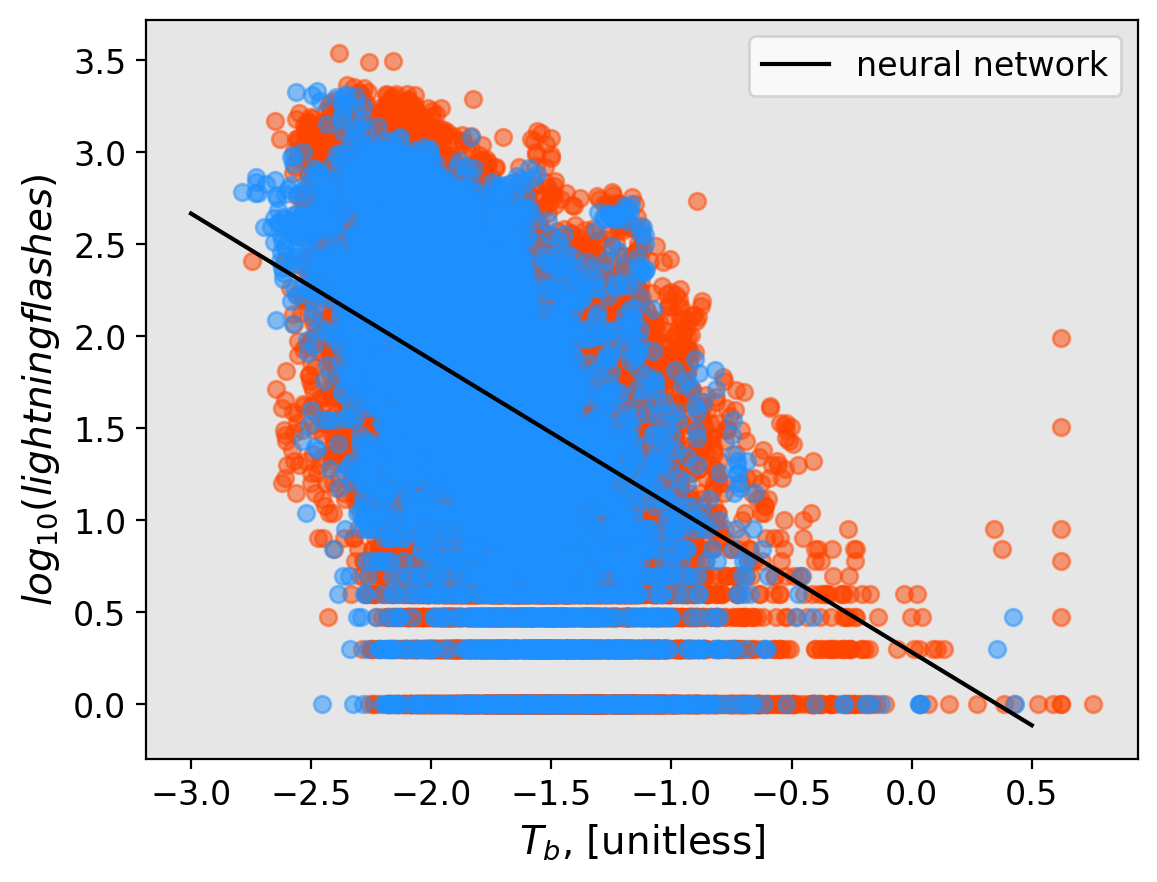

In [29]:
model.eval() # Set to evaluation mode

with torch.no_grad():
    yhat = model(x_dummy_tensor)  # same inputs with before-training model 

#plot to check it looks right
plt.plot(X_t,y_t,'o',color='orangered',alpha=0.5)
plt.plot(X_v,y_v,'o',color='dodgerblue',alpha=0.5)

plt.plot(x_dummy, yhat.numpy(),'-k',label='neural network')
plt.legend()
plt.xlabel('$T_b$, [unitless]')
plt.ylabel('$log_{10}(lightning flashes)$')


 Not bad\! Typically it takes many epochs to train a neural network, but here because the perceptron has only 2 trainable parameters, it doesnt take much to train.



 We can now interrogate our model and look at the newly trained parameters\!

In [30]:
print("Weights:", model[0].weight)
print("Bias:", model[0].bias)


Weights: Parameter containing:
tensor([[-0.7944]], requires_grad=True)
Bias: Parameter containing:
tensor([0.2840], requires_grad=True)


Hopefully you are now a bit more familiar with PyTorch and how it works. These concepts will be further explored and refined in the next example notebooks.